In [1]:
import torch
import torch.nn as nn
import numpy as np
from unet import UNet
import matplotlib.pyplot as plt

In [2]:
torch.cuda.set_device(0)
device = torch.device('cuda')
loss_function = nn.BCEWithLogitsLoss()

In [3]:
images = torch.tensor(np.load("images.npy"), dtype=torch.float32)
masks = torch.tensor(np.load("masks.npy"), dtype=torch.float32)

split = int(images.shape[0]*0.9)
train_images = images[:split]
train_labels = masks[:split]

val_images = images[split:]
val_labels = masks[split:]

print(train_labels.shape)
print(val_labels.shape)

torch.Size([1213, 224, 224])
torch.Size([135, 224, 224])


In [4]:
model = UNet(num_classes=1, in_channels=3, depth=5, merge_mode='concat')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.to(device)

UNet(
  (conv_final): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DownConv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): DownConv(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): DownConv(
      (conv1): Conv2d(256, 512, kernel_size=(3, 

In [5]:
def val_loss():
	val_losses = []
	for i in range(val_images.shape[0]):
		val_losses.append(loss_function(model(val_images[i:i+1].permute(0, 3, 1, 2).to(device)).squeeze(), val_labels[i:i+1].to(device).squeeze()).item())
	return (sum(val_losses)/len(val_losses))

In [6]:
losses = []

In [7]:
n_epochs = 100
batch_size = 16

for epoch in range(n_epochs):
	permutation = torch.randperm(train_images.shape[0])
	for i in range(0, permutation.shape[0], batch_size):
		optimizer.zero_grad()

		indices = permutation[i:i+batch_size]
		x, y = train_images[indices], train_labels[indices]

		x = x.to(device)
		y = y.to(device)

		logits = model(x.permute(0, 3, 1, 2))
		loss = loss_function(logits.squeeze(), y.squeeze())
		losses.append(loss.item())
		
		loss.backward()
		optimizer.step()
	print(val_loss())

0.10091994666942844
0.059184006877519464
0.051073321562122416
0.0399318330541805
0.027804728404239372
0.024480969441571722
0.019718167520369645
0.017084600052071942
0.016193389361379325
0.014447007959501611
0.013856461306137068
0.012714922293606731
0.017853034739555032
0.011228237320082607
0.010124963333968211
0.00970160397183564
0.009068040466970868
0.009867107288704978
0.00824713608663943
0.008150154405652924
0.00740383453839631
0.006578338177253802
0.009590605292814197
0.007253848123191684
0.007014118502330449
0.005623224326754334
0.005506406844317637
0.005458535039280024
0.0059453410510387685
0.00536718282641636
0.011191711797275477
0.006318089998051248
0.018147355894972052
0.00572695282753557
0.006637798659330993
0.004761288169323018
0.004460020264162233
0.0045476666004914375
0.004271161676108561
0.004279433952265039
0.004616223077324254


KeyboardInterrupt: 

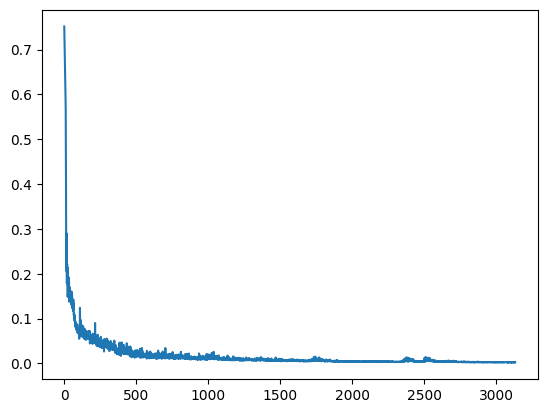

In [8]:
plt.plot(losses)

In [19]:
print(val_images.shape)

torch.Size([135, 224, 224, 3])


In [45]:
index = 1
m = torch.sigmoid(model(val_images[index:index+1].permute(0, 3, 1, 2).to(device)).squeeze()).cpu().detach().numpy()

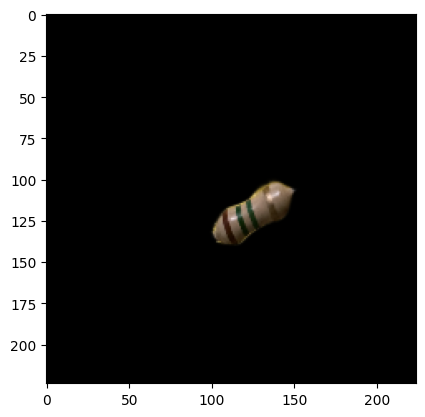

In [51]:
t = val_images[index:index+1].squeeze()
r = t[:, :, 0]
g = t[:, :, 1]
b = t[:, :, 2]

r = (r*0.229) + 0.485
g = (g*0.224) + 0.456
b = (b*0.225) + 0.406

t = torch.stack([r, g, b], dim=2)

plt.imshow(t.squeeze() * m.reshape(224, 224, 1))
# plt.imshow(t.squeeze())
# plt.imshow(m.reshape(224, 224, 1))